# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [10]:
student1 = "Pau Argelaguet Franquelo"
student2 = "Natalie Bolon Brun"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [11]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

from keras.models import Sequential
from keras.layers import Dense, Activation

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
np.random.seed(hash(student1 + student2) % 2**32)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

### Plotting

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [13]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('data/train_32x32.mat')
data_test = scipy.io.loadmat('data/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [14]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

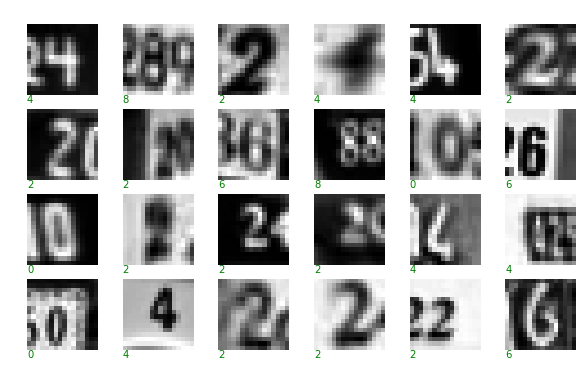

In [15]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [16]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [17]:
model = Sequential([
    Dense(32, input_shape=(256,)),
    Activation('relu'),
    Dense(5),
    Activation('softmax'),
])

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=1000, validation_split=0.2, batch_size=128, verbose=1)

Train on 27010 samples, validate on 6753 samples
Epoch 1/1000
27010/27010 [==============================] - 0s 17us/step - loss: 1.4233 - acc: 0.3789 - val_loss: 3.3199 - val_acc: 2.9616e-04
Epoch 2/1000
27010/27010 [==============================] - 1s 41us/step - loss: 1.3566 - acc: 0.3846 - val_loss: 3.9296 - val_acc: 0.0000e+00
Epoch 3/1000
27010/27010 [==============================] - 1s 34us/step - loss: 1.3346 - acc: 0.3912 - val_loss: 4.3947 - val_acc: 0.0000e+00
Epoch 4/1000
27010/27010 [==============================] - 0s 15us/step - loss: 1.3210 - acc: 0.3948 - val_loss: 4.7527 - val_acc: 0.0000e+00
Epoch 5/1000
27010/27010 [==============================] - 0s 16us/step - loss: 1.3105 - acc: 0.3987 - val_loss: 5.0342 - val_acc: 0.0000e+00
Epoch 6/1000
27010/27010 [==============================] - 0s 16us/step - loss: 1.3010 - acc: 0.4034 - val_loss: 5.2660 - val_acc: 0.0000e+00
Epoch 7/1000
27010/27010 [==============================] - 0s 15us/step - loss: 1.2912 - acc

Epoch 59/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.7108 - acc: 0.7538 - val_loss: 8.3067 - val_acc: 0.0167
Epoch 60/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.7074 - acc: 0.7542 - val_loss: 8.1018 - val_acc: 0.1254
Epoch 61/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.7023 - acc: 0.7569 - val_loss: 8.1619 - val_acc: 0.0888
Epoch 62/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.6973 - acc: 0.7585 - val_loss: 8.2051 - val_acc: 0.0715
Epoch 63/1000
27010/27010 [==============================] - 1s 24us/step - loss: 0.6930 - acc: 0.7605 - val_loss: 8.2918 - val_acc: 0.0663
Epoch 64/1000
27010/27010 [==============================] - 1s 20us/step - loss: 0.6893 - acc: 0.7626 - val_loss: 8.2268 - val_acc: 0.0794
Epoch 65/1000
27010/27010 [==============================] - 0s 16us/step - loss: 0.6845 - acc: 0.7671 - val_loss: 8.2754 - val_acc: 0.0668
Epoch 66/1000
27010/

27010/27010 [==============================] - 0s 16us/step - loss: 0.5569 - acc: 0.8141 - val_loss: 8.8155 - val_acc: 0.1410
Epoch 118/1000
27010/27010 [==============================] - 0s 16us/step - loss: 0.5554 - acc: 0.8155 - val_loss: 8.8776 - val_acc: 0.1251
Epoch 119/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.5546 - acc: 0.8154 - val_loss: 8.8204 - val_acc: 0.1460
Epoch 120/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.5527 - acc: 0.8170 - val_loss: 8.8459 - val_acc: 0.1385
Epoch 121/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.5513 - acc: 0.8156 - val_loss: 8.8775 - val_acc: 0.1266
Epoch 122/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.5505 - acc: 0.8165 - val_loss: 8.8781 - val_acc: 0.1316
Epoch 123/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.5487 - acc: 0.8183 - val_loss: 8.8767 - val_acc: 0.1361
Epoch 124/1000
27010/27010 [

27010/27010 [==============================] - 0s 15us/step - loss: 0.4967 - acc: 0.8362 - val_loss: 9.1809 - val_acc: 0.1552
Epoch 176/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.4962 - acc: 0.8360 - val_loss: 9.1957 - val_acc: 0.1491
Epoch 177/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.4955 - acc: 0.8365 - val_loss: 9.2000 - val_acc: 0.1496
Epoch 178/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.4946 - acc: 0.8370 - val_loss: 9.2007 - val_acc: 0.1487
Epoch 179/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.4937 - acc: 0.8364 - val_loss: 9.1981 - val_acc: 0.1525
Epoch 180/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.4929 - acc: 0.8380 - val_loss: 9.1954 - val_acc: 0.1580
Epoch 181/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.4921 - acc: 0.8381 - val_loss: 9.1913 - val_acc: 0.1596
Epoch 182/1000
27010/27010 [

Epoch 233/1000
27010/27010 [==============================] - 1s 20us/step - loss: 0.4563 - acc: 0.8489 - val_loss: 9.3608 - val_acc: 0.1696
Epoch 234/1000
27010/27010 [==============================] - 1s 20us/step - loss: 0.4556 - acc: 0.8491 - val_loss: 9.3532 - val_acc: 0.1778
Epoch 235/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.4550 - acc: 0.8497 - val_loss: 9.3731 - val_acc: 0.1657
Epoch 236/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.4543 - acc: 0.8495 - val_loss: 9.3670 - val_acc: 0.1707
Epoch 237/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.4539 - acc: 0.8493 - val_loss: 9.3565 - val_acc: 0.1804
Epoch 238/1000
27010/27010 [==============================] - 1s 43us/step - loss: 0.4539 - acc: 0.8499 - val_loss: 9.4543 - val_acc: 0.1459
Epoch 239/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.4557 - acc: 0.8494 - val_loss: 9.3937 - val_acc: 0.1620
Epoch 240/100

27010/27010 [==============================] - 0s 15us/step - loss: 0.4234 - acc: 0.8606 - val_loss: 9.5397 - val_acc: 0.1694
Epoch 292/1000
27010/27010 [==============================] - 0s 16us/step - loss: 0.4229 - acc: 0.8618 - val_loss: 9.5508 - val_acc: 0.1645
Epoch 293/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.4221 - acc: 0.8615 - val_loss: 9.5422 - val_acc: 0.1715
Epoch 294/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.4214 - acc: 0.8615 - val_loss: 9.5468 - val_acc: 0.1709
Epoch 295/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.4212 - acc: 0.8623 - val_loss: 9.5536 - val_acc: 0.1707
Epoch 296/1000
27010/27010 [==============================] - 0s 17us/step - loss: 0.4209 - acc: 0.8617 - val_loss: 9.5643 - val_acc: 0.1642
Epoch 297/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.4203 - acc: 0.8628 - val_loss: 9.5444 - val_acc: 0.1737
Epoch 298/1000
27010/27010 [

27010/27010 [==============================] - 0s 14us/step - loss: 0.3941 - acc: 0.8729 - val_loss: 9.6515 - val_acc: 0.1855
Epoch 350/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.3934 - acc: 0.8725 - val_loss: 9.6515 - val_acc: 0.1892
Epoch 351/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.3935 - acc: 0.8722 - val_loss: 9.6837 - val_acc: 0.1703
Epoch 352/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.3929 - acc: 0.8726 - val_loss: 9.6709 - val_acc: 0.1774
Epoch 353/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.3922 - acc: 0.8725 - val_loss: 9.7182 - val_acc: 0.1537
Epoch 354/1000
27010/27010 [==============================] - 0s 16us/step - loss: 0.3925 - acc: 0.8732 - val_loss: 9.7547 - val_acc: 0.1472
Epoch 355/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.3920 - acc: 0.8726 - val_loss: 9.6690 - val_acc: 0.1897
Epoch 356/1000
27010/27010 [

27010/27010 [==============================] - 1s 22us/step - loss: 0.3692 - acc: 0.8805 - val_loss: 9.8776 - val_acc: 0.1466
Epoch 408/1000
27010/27010 [==============================] - 1s 20us/step - loss: 0.3715 - acc: 0.8806 - val_loss: 9.7744 - val_acc: 0.1746
Epoch 409/1000
27010/27010 [==============================] - 1s 19us/step - loss: 0.3683 - acc: 0.8817 - val_loss: 9.7948 - val_acc: 0.1681
Epoch 410/1000
27010/27010 [==============================] - 0s 16us/step - loss: 0.3686 - acc: 0.8814 - val_loss: 9.7882 - val_acc: 0.1721
Epoch 411/1000
27010/27010 [==============================] - 0s 16us/step - loss: 0.3678 - acc: 0.8805 - val_loss: 9.7753 - val_acc: 0.1804
Epoch 412/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.3674 - acc: 0.8826 - val_loss: 9.8153 - val_acc: 0.1627
Epoch 413/1000
27010/27010 [==============================] - 0s 16us/step - loss: 0.3672 - acc: 0.8816 - val_loss: 9.7534 - val_acc: 0.2100
Epoch 414/1000
27010/27010 [

27010/27010 [==============================] - 1s 23us/step - loss: 0.3483 - acc: 0.8890 - val_loss: 9.8632 - val_acc: 0.1808
Epoch 466/1000
27010/27010 [==============================] - 1s 27us/step - loss: 0.3476 - acc: 0.8897 - val_loss: 9.8608 - val_acc: 0.1793
Epoch 467/1000
27010/27010 [==============================] - 1s 26us/step - loss: 0.3476 - acc: 0.8892 - val_loss: 9.8585 - val_acc: 0.1857
Epoch 468/1000
27010/27010 [==============================] - 0s 18us/step - loss: 0.3473 - acc: 0.8904 - val_loss: 9.8601 - val_acc: 0.1833
Epoch 469/1000
27010/27010 [==============================] - 1s 21us/step - loss: 0.3467 - acc: 0.8887 - val_loss: 9.8720 - val_acc: 0.1780
Epoch 470/1000
27010/27010 [==============================] - 1s 25us/step - loss: 0.3465 - acc: 0.8900 - val_loss: 9.8712 - val_acc: 0.1808
Epoch 471/1000
27010/27010 [==============================] - 2s 61us/step - loss: 0.3459 - acc: 0.8894 - val_loss: 9.8629 - val_acc: 0.1811
Epoch 472/1000
27010/27010 [

27010/27010 [==============================] - 0s 16us/step - loss: 0.3305 - acc: 0.8949 - val_loss: 9.9232 - val_acc: 0.1987
Epoch 524/1000
27010/27010 [==============================] - 0s 18us/step - loss: 0.3309 - acc: 0.8950 - val_loss: 9.9382 - val_acc: 0.1823
Epoch 525/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.3302 - acc: 0.8953 - val_loss: 9.9177 - val_acc: 0.2094
Epoch 526/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.3297 - acc: 0.8959 - val_loss: 9.9271 - val_acc: 0.1932
Epoch 527/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.3294 - acc: 0.8955 - val_loss: 9.9695 - val_acc: 0.1731
Epoch 528/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.3294 - acc: 0.8955 - val_loss: 9.9405 - val_acc: 0.1863
Epoch 529/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.3290 - acc: 0.8963 - val_loss: 9.9556 - val_acc: 0.1790
Epoch 530/1000
27010/27010 [

27010/27010 [==============================] - 0s 14us/step - loss: 0.3158 - acc: 0.8998 - val_loss: 9.9948 - val_acc: 0.1909
Epoch 582/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.3154 - acc: 0.9004 - val_loss: 10.0089 - val_acc: 0.1827
Epoch 583/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.3149 - acc: 0.9005 - val_loss: 10.0046 - val_acc: 0.1804
Epoch 584/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.3148 - acc: 0.9008 - val_loss: 9.9917 - val_acc: 0.1980
Epoch 585/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.3148 - acc: 0.9004 - val_loss: 9.9905 - val_acc: 0.2021
Epoch 586/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.3143 - acc: 0.9006 - val_loss: 10.0042 - val_acc: 0.1881
Epoch 587/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.3138 - acc: 0.9007 - val_loss: 10.0186 - val_acc: 0.2203
Epoch 588/1000
27010/270

Epoch 639/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.3022 - acc: 0.9044 - val_loss: 10.0695 - val_acc: 0.1935
Epoch 640/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.3030 - acc: 0.9056 - val_loss: 10.0728 - val_acc: 0.1820
Epoch 641/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.3020 - acc: 0.9045 - val_loss: 10.0544 - val_acc: 0.1978
Epoch 642/1000
27010/27010 [==============================] - 0s 16us/step - loss: 0.3021 - acc: 0.9051 - val_loss: 10.0603 - val_acc: 0.1873
Epoch 643/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.3021 - acc: 0.9041 - val_loss: 10.0679 - val_acc: 0.1854
Epoch 644/1000
27010/27010 [==============================] - 1s 23us/step - loss: 0.3031 - acc: 0.9037 - val_loss: 10.0617 - val_acc: 0.1921
Epoch 645/1000
27010/27010 [==============================] - 1s 24us/step - loss: 0.3015 - acc: 0.9042 - val_loss: 10.0563 - val_acc: 0.1950
Epoch 

Epoch 697/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.2912 - acc: 0.9087 - val_loss: 10.1221 - val_acc: 0.1887
Epoch 698/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.2912 - acc: 0.9092 - val_loss: 10.1161 - val_acc: 0.1919
Epoch 699/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.2906 - acc: 0.9101 - val_loss: 10.1143 - val_acc: 0.1940
Epoch 700/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2907 - acc: 0.9093 - val_loss: 10.1169 - val_acc: 0.1909
Epoch 701/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2902 - acc: 0.9094 - val_loss: 10.1164 - val_acc: 0.1919
Epoch 702/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2906 - acc: 0.9090 - val_loss: 10.1197 - val_acc: 0.1946
Epoch 703/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2909 - acc: 0.9091 - val_loss: 10.1150 - val_acc: 0.1968
Epoch 

Epoch 755/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.2810 - acc: 0.9133 - val_loss: 10.1652 - val_acc: 0.1925
Epoch 756/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.2807 - acc: 0.9126 - val_loss: 10.1714 - val_acc: 0.2242
Epoch 757/1000
27010/27010 [==============================] - 1s 46us/step - loss: 0.2825 - acc: 0.9118 - val_loss: 10.1705 - val_acc: 0.1931
Epoch 758/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2804 - acc: 0.9133 - val_loss: 10.1692 - val_acc: 0.1930
Epoch 759/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2801 - acc: 0.9124 - val_loss: 10.1618 - val_acc: 0.2100
Epoch 760/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.2803 - acc: 0.9131 - val_loss: 10.1850 - val_acc: 0.1878
Epoch 761/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2803 - acc: 0.9124 - val_loss: 10.1902 - val_acc: 0.1814
Epoch 

Epoch 813/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.2719 - acc: 0.9159 - val_loss: 10.2368 - val_acc: 0.1904
Epoch 814/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2716 - acc: 0.9157 - val_loss: 10.2352 - val_acc: 0.1965
Epoch 815/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2718 - acc: 0.9162 - val_loss: 10.2313 - val_acc: 0.1995
Epoch 816/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2715 - acc: 0.9170 - val_loss: 10.2436 - val_acc: 0.1890
Epoch 817/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2716 - acc: 0.9156 - val_loss: 10.2317 - val_acc: 0.1975
Epoch 818/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2713 - acc: 0.9169 - val_loss: 10.2341 - val_acc: 0.1974
Epoch 819/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2708 - acc: 0.9167 - val_loss: 10.2325 - val_acc: 0.1975
Epoch 

Epoch 871/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2631 - acc: 0.9194 - val_loss: 10.3214 - val_acc: 0.1844
Epoch 872/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.2637 - acc: 0.9191 - val_loss: 10.2929 - val_acc: 0.1882
Epoch 873/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2631 - acc: 0.9185 - val_loss: 10.2879 - val_acc: 0.1962
Epoch 874/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2630 - acc: 0.9195 - val_loss: 10.3215 - val_acc: 0.1876
Epoch 875/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2638 - acc: 0.9181 - val_loss: 10.2895 - val_acc: 0.1938
Epoch 876/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2626 - acc: 0.9197 - val_loss: 10.2784 - val_acc: 0.2030
Epoch 877/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2624 - acc: 0.9188 - val_loss: 10.3149 - val_acc: 0.2282
Epoch 

Epoch 929/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.2572 - acc: 0.9220 - val_loss: 10.3323 - val_acc: 0.2044
Epoch 930/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2558 - acc: 0.9217 - val_loss: 10.3346 - val_acc: 0.2042
Epoch 931/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2557 - acc: 0.9221 - val_loss: 10.3362 - val_acc: 0.2036
Epoch 932/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2551 - acc: 0.9214 - val_loss: 10.3349 - val_acc: 0.2027
Epoch 933/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2552 - acc: 0.9227 - val_loss: 10.3376 - val_acc: 0.2011
Epoch 934/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.2554 - acc: 0.9220 - val_loss: 10.3470 - val_acc: 0.1961
Epoch 935/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2551 - acc: 0.9213 - val_loss: 10.3348 - val_acc: 0.2161
Epoch 

Epoch 987/1000
27010/27010 [==============================] - 1s 19us/step - loss: 0.2490 - acc: 0.9244 - val_loss: 10.3703 - val_acc: 0.2252
Epoch 988/1000
27010/27010 [==============================] - 1s 20us/step - loss: 0.2494 - acc: 0.9239 - val_loss: 10.3609 - val_acc: 0.2046
Epoch 989/1000
27010/27010 [==============================] - 1s 19us/step - loss: 0.2484 - acc: 0.9247 - val_loss: 10.3640 - val_acc: 0.1986
Epoch 990/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.2483 - acc: 0.9234 - val_loss: 10.3721 - val_acc: 0.1953
Epoch 991/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.2479 - acc: 0.9242 - val_loss: 10.3689 - val_acc: 0.1967
Epoch 992/1000
27010/27010 [==============================] - 0s 15us/step - loss: 0.2483 - acc: 0.9242 - val_loss: 10.3670 - val_acc: 0.1967
Epoch 993/1000
27010/27010 [==============================] - 0s 14us/step - loss: 0.2476 - acc: 0.9244 - val_loss: 10.3583 - val_acc: 0.2060
Epoch 

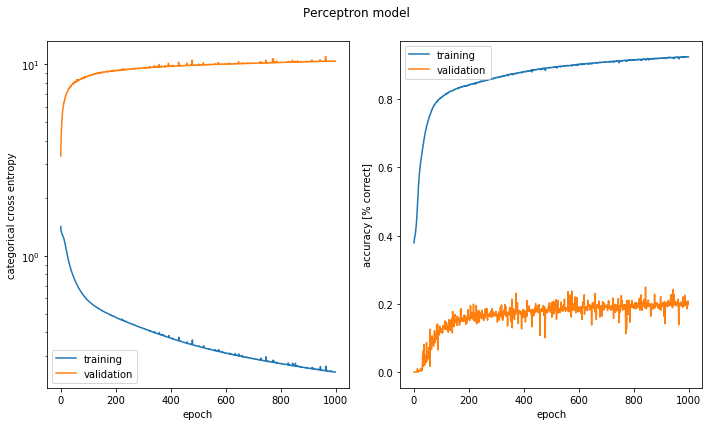

In [18]:
ph = plot_history(history, "Perceptron model")

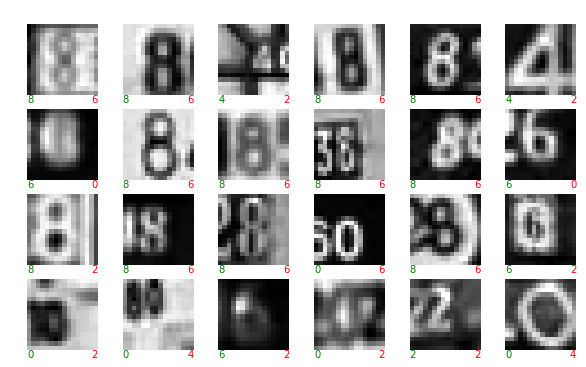

In [19]:
yhat_test= model.predict_on_batch(x_test)
error = np.linalg.norm(((yhat_test.round()) - y_test),axis=1)
error_indices = np.nonzero(error)[0]

ps = plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

In [20]:
model = Sequential([
    Dense(64, input_shape=(256,)),
    Activation('relu'),
    Dense(64),
    Activation('relu'),
    Dense(5),
    Activation('softmax'),
])
lrates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5]
histories = []
for lrate in lrates:
    model.compile(optimizer=SGD(lr=lrate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    model.summary()
    histories.append(model.fit(x_train, y_train, epochs=50, validation_split=0.2, batch_size=128, verbose=1))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_6 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
_________________________________________________________________
activation_7 (Activation)    (None, 5)                 0         
Total params: 20,933
Trainable params: 20,933
Non-trainable params: 0
_________________________________________________________________
Train 

27010/27010 [==============================] - 1s 26us/step - loss: 1.2836 - acc: 0.4225 - val_loss: 5.1033 - val_acc: 0.0000e+00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_6 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
_________________________________________________________________
activation_7 (Activation)    (None, 5)                 0         
Total params

27010/27010 [==============================] - 1s 19us/step - loss: 0.6806 - acc: 0.7459 - val_loss: 7.8954 - val_acc: 0.0585
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_6 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
_________________________________________________________________
activation_7 (Activation)    (None, 5)                 0         
Total params: 20

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_6 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
_________________________________________________________________
activation_7 (Activation)    (None, 5)                 0         
Total params: 20,933
Trainable params: 20,933
Non-trainable params: 0
_________________________________________________________________
Train 

Train on 27010 samples, validate on 6753 samples
Epoch 1/50
27010/27010 [==============================] - 1s 22us/step - loss: 0.4492 - acc: 0.8472 - val_loss: 6.8252 - val_acc: 0.0964
Epoch 2/50
27010/27010 [==============================] - 0s 17us/step - loss: 0.4593 - acc: 0.8380 - val_loss: 6.9670 - val_acc: 0.1887
Epoch 3/50
27010/27010 [==============================] - 0s 18us/step - loss: 0.3546 - acc: 0.8753 - val_loss: 9.2416 - val_acc: 0.1202
Epoch 4/50
27010/27010 [==============================] - 0s 17us/step - loss: 0.4448 - acc: 0.8496 - val_loss: 8.0591 - val_acc: 0.0903
Epoch 5/50
27010/27010 [==============================] - 0s 18us/step - loss: 0.3746 - acc: 0.8707 - val_loss: 8.2014 - val_acc: 0.1023
Epoch 6/50
27010/27010 [==============================] - 0s 18us/step - loss: 0.4644 - acc: 0.8419 - val_loss: 5.6515 - val_acc: 0.1813
Epoch 7/50
27010/27010 [==============================] - 0s 17us/step - loss: 0.3234 - acc: 0.8860 - val_loss: 6.7411 - val_acc:

27010/27010 [==============================] - 1s 22us/step - loss: 1.4567 - acc: 0.6002 - val_loss: 13.0012 - val_acc: 0.0135
Epoch 2/50
27010/27010 [==============================] - 0s 18us/step - loss: 1.2370 - acc: 0.4969 - val_loss: 4.5082 - val_acc: 0.0554
Epoch 3/50
27010/27010 [==============================] - 0s 18us/step - loss: 0.8017 - acc: 0.6772 - val_loss: 7.9030 - val_acc: 0.0447
Epoch 4/50
27010/27010 [==============================] - 0s 18us/step - loss: 0.7290 - acc: 0.7215 - val_loss: 7.3549 - val_acc: 0.1815
Epoch 5/50
27010/27010 [==============================] - 1s 32us/step - loss: 0.6169 - acc: 0.7700 - val_loss: 14.1103 - val_acc: 0.0022
Epoch 6/50
27010/27010 [==============================] - 0s 18us/step - loss: 0.7122 - acc: 0.7375 - val_loss: 6.9349 - val_acc: 0.1419
Epoch 7/50
27010/27010 [==============================] - 0s 17us/step - loss: 0.4820 - acc: 0.8306 - val_loss: 15.9502 - val_acc: 1.4808e-04
Epoch 8/50
27010/27010 [=====================

27010/27010 [==============================] - 1s 23us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 2/50
27010/27010 [==============================] - 0s 18us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 3/50
27010/27010 [==============================] - 1s 19us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 4/50
27010/27010 [==============================] - 0s 18us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 5/50
27010/27010 [==============================] - 1s 19us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 6/50
27010/27010 [==============================] - 0s 18us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 7/50
27010/27010 [==============================] - 3s 93us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 8/50
27010/27010 [==============

27010/27010 [==============================] - 1s 24us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 2/50
27010/27010 [==============================] - 0s 18us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 3/50
27010/27010 [==============================] - 1s 20us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 4/50
27010/27010 [==============================] - 1s 19us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 5/50
27010/27010 [==============================] - 0s 18us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 6/50
27010/27010 [==============================] - 1s 19us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 7/50
27010/27010 [==============================] - 3s 93us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 8/50
27010/27010 [==============

27010/27010 [==============================] - 1s 23us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 2/50
27010/27010 [==============================] - 0s 18us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 3/50
27010/27010 [==============================] - 1s 33us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 4/50
27010/27010 [==============================] - 0s 17us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 5/50
27010/27010 [==============================] - 0s 18us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 6/50
27010/27010 [==============================] - 0s 18us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 7/50
27010/27010 [==============================] - 0s 17us/step - loss: 13.7198 - acc: 0.1488 - val_loss: 12.0414 - val_acc: 0.2529
Epoch 8/50
27010/27010 [==============

In [26]:
for h in histories:
    print(h.history.get('loss')[-1])

1.28358922472
0.680616144523
0.441430279994
0.257579681835
0.210406610782
13.7197799256
13.7197798824
13.7197799185
13.7197799231


In [29]:
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

adam_history = model.fit(x_train, y_train, epochs=50, validation_split=0.2, batch_size=128, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_6 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
_________________________________________________________________
activation_7 (Activation)    (None, 5)                 0         
Total params: 20,933
Trainable params: 20,933
Non-trainable params: 0
_________________________________________________________________
Train 

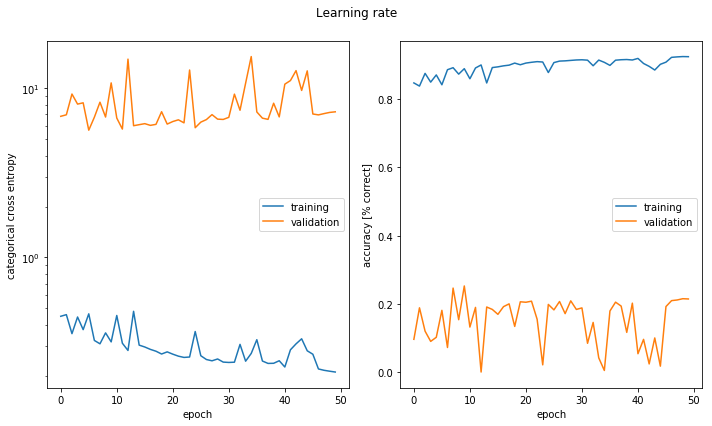

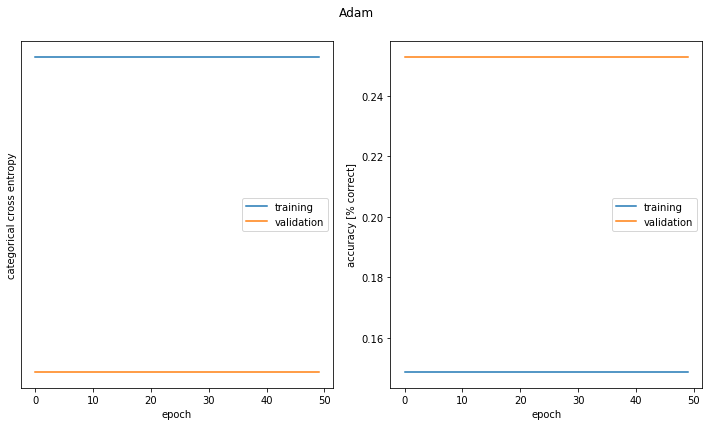

In [30]:
plot_lr = plot_history(histories[4], "Learning rate")
plot_adam = plot_history(adam_history, "Adam")
plt.show()

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) The algorithm may not converge and oscilate arround a minimum.

B) The algorithm will eventually reach a local minimum but it can take a 👀👀👀 number of iterations.

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

In [31]:
model = Sequential([
    Dense(64, input_shape=(256,)),
    Activation('relu'),
    Dense(64),
    Activation('relu'),
    Dense(5),
    Activation('softmax'),
])

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=50, validation_split=0.2, batch_size=128, verbose=1)

Train on 27010 samples, validate on 6753 samples
Epoch 1/50
27010/27010 [==============================] - 1s 29us/step - loss: 1.1863 - acc: 0.5014 - val_loss: 7.5834 - val_acc: 0.0043
Epoch 2/50
27010/27010 [==============================] - 1s 19us/step - loss: 0.7554 - acc: 0.7237 - val_loss: 8.3924 - val_acc: 0.1333
Epoch 3/50
27010/27010 [==============================] - 1s 19us/step - loss: 0.6275 - acc: 0.7834 - val_loss: 8.7206 - val_acc: 0.1143
Epoch 4/50
27010/27010 [==============================] - 1s 20us/step - loss: 0.5670 - acc: 0.8073 - val_loss: 8.8564 - val_acc: 0.1336
Epoch 5/50
27010/27010 [==============================] - 2s 76us/step - loss: 0.5226 - acc: 0.8241 - val_loss: 8.8495 - val_acc: 0.1608
Epoch 6/50
27010/27010 [==============================] - 1s 21us/step - loss: 0.4909 - acc: 0.8358 - val_loss: 9.2327 - val_acc: 0.1491
Epoch 7/50
27010/27010 [==============================] - 1s 19us/step - loss: 0.4713 - acc: 0.8398 - val_loss: 9.3222 - val_acc:

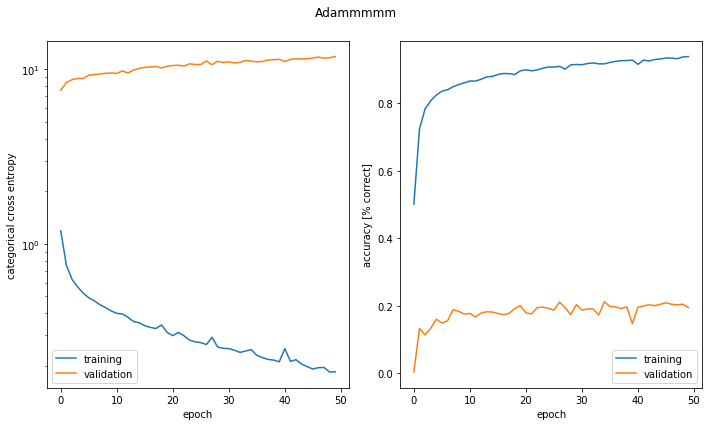

In [33]:
p = plot_history(history, "Adammmmm")

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: 

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: 

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution